## CSC Updater 

This notebook walks you through the CSC updater on a single learning task.

Importing libraries:

In [1]:
import numpy as np
import pandas as pd
import copy

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import ensemble

import model
import verifier
import cscUpdater

import importlib as imp

import warnings
warnings.filterwarnings('ignore')

Importing in the ACS dataset.

In [2]:
import acsDataParallel

test_size = 0.2 #train-test split

acs_task = 'income' # options: employment, income, public_coverage, mobility, and travel_time.
acs_year = 2016 #must be >= 2014. Upper bound unknown.
acs_states = ['NY']
acs_horizon='1-Year' #1-Year or 5-Year
acs_survey='person' #'person' or 'household'

# for subsampling rows: can specify first and last of data to be pulled. currently pulling everything.
row_start = 0 
row_end = 1000

# for subsampling columns. note: can only subsample consecutive columns with current implementation
col_start=0
col_end=-1

[train_x, train_y, test_x, test_y, demo_group_functions, demo_group_indicators, min_age, mid_age] = acsDataParallel.get_data(
    test_size, acs_task, acs_year, acs_states,acs_horizon=acs_horizon, acs_survey=acs_survey, row_start = row_start,
    row_end = row_end, col_start=col_start, col_end=col_end)

Initializing our model to a decision stump

In [3]:
initial_model = DecisionTreeClassifier(max_depth = 1, random_state=0)
initial_model.fit(train_x, train_y);

Here's where we build the updater. 

In [4]:
imp.reload(cscUpdater)
imp.reload(model)
imp.reload(verifier)

def verify_size(x, group):
    # helper function that checks that the discovered group isn't too small to run on
    g_indices = group(x)
    g_xs = x[g_indices]
    if len(g_xs) == 0:
        return False
    else:
        return True

def run_updates(n_rounds):
    # build the initial model
    mod = model.PointerDecisionList(initial_model.predict, [])
    mod.test_errors.append(cscUpdater.measure_group_errors(mod, test_x, test_y))
    mod.train_errors.append(cscUpdater.measure_group_errors(mod, train_x, train_y))
    
    gs_to_update = []
 
    for i in range(n_rounds):
        print(i)
        # get the predicted ys for the current model
        pred_y = np.array(mod.predict(train_x),dtype=bool)
        # train the cost regressions
        [r0, r1, _] = cscUpdater.training_r0_r1(train_x, train_y, pred_y)
        # generate your u_g and h
        u_g = cscUpdater.g_gen(r0, r1)
        h = cscUpdater.h_gen(r0, r1)
        
        # run a check to see if the u_g and h are a) too small or b) don't improve compared to the current model
        size_check = verify_size(test_x, u_g)
        if size_check:
            improvement_check = verifier.is_proposed_group_good_csc(mod, test_x, test_y, h, u_g)
        else:
            print("Group discovered not contained in test set, quitting update process")
            break
            
        # if they pass the check, run the update
        if improvement_check:
            # run the update
            cscUpdater.iterative_update(mod, h, u_g, train_x, train_y, test_x, test_y, "u_g%s" % i)
            
        # otherwise stop running
        else:
            print("Proposed group does not improve model, quitting update process")
            break
        
        gs_to_update.append(u_g)
            
    return [mod, gs_to_update, mod.test_errors, mod.train_errors]

The below runs the CSC updater for a number of rounds specified by num_rounds (Or less, if the model stops improving or g gets too small)

In [5]:
num_rounds = 4
[f, gs, test_errors, train_errors] = run_updates(num_rounds)

0
Error of current model on proposed group: 0.6599999999999999
Error of h trained on proposed group: 0.33999999999999997
1
Error of current model on proposed group: 0.25
Error of h trained on proposed group: 0.75
Proposed group does not improve model, quitting update process


Finally, we can plot performance.

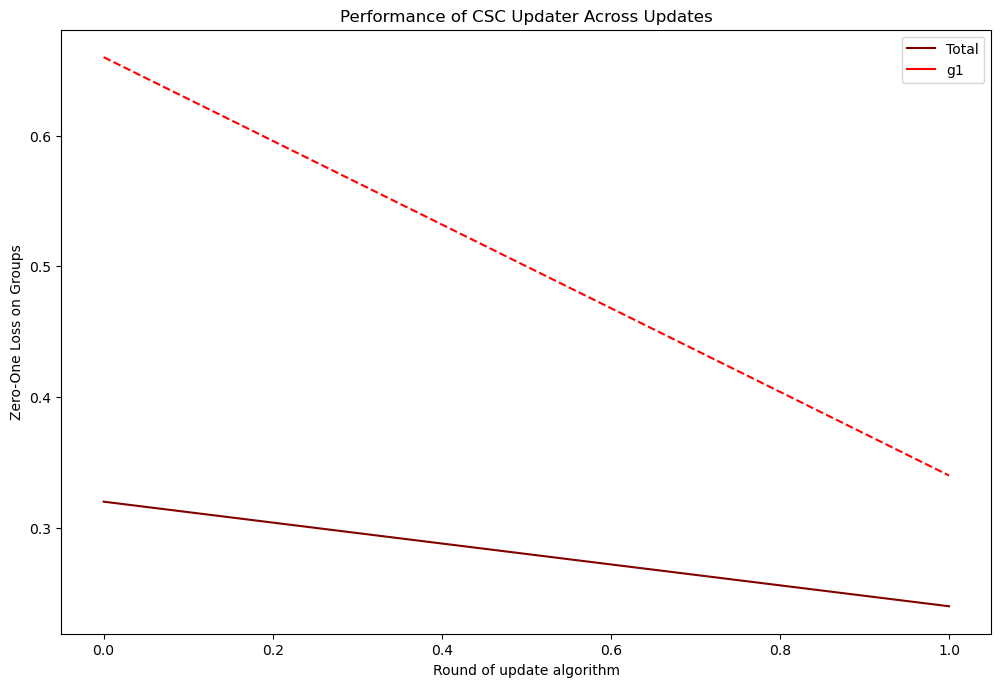

In [6]:
import matplotlib.pyplot as plt

test_errors_by_group = [[test_errors[j][i] for j in range(len(test_errors))] 
                        for i in range(len(test_errors))]

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # make plot bigger

xs = np.arange(len(test_errors))
colors = ['maroon', 'red', 'orange',
          'chartreuse', 'green', 'blue', 'deepskyblue',
          'purple', 'plum',  'pink', 'gray', 'fuchsia', 'black']
group_indicators =  ['Total'] + ['g%s'%(i+1) for i in range(len(gs))]
for i in range(len(test_errors_by_group)):
    plt.plot(xs[i:], test_errors_by_group[i][i:], color=colors[i], label = group_indicators[i])
    plt.plot(xs[:i+1], test_errors_by_group[i][:i+1], linestyle='--', color=colors[i])
plt.legend()
plt.xlabel('Round of update algorithm')
plt.ylabel("Zero-One Loss on Groups")
plt.title("Performance of CSC Updater Across Updates")
plt.savefig("CSC_errs.png")

We can also look at the performance of the different demographic groups over multiple rounds:

In [7]:
demo_errs = []
i = 0
for g in [lambda x: np.ones(len(x),dtype=bool)] + demo_group_functions:
    indices = g(test_x) == 1
    ys = test_y[indices]
    if len(ys) > 0:
        demo_errs.append(cscUpdater.all_group_errors(f, g, test_x, test_y))
    else:
        demo_errs.append([-1])
    i+=1

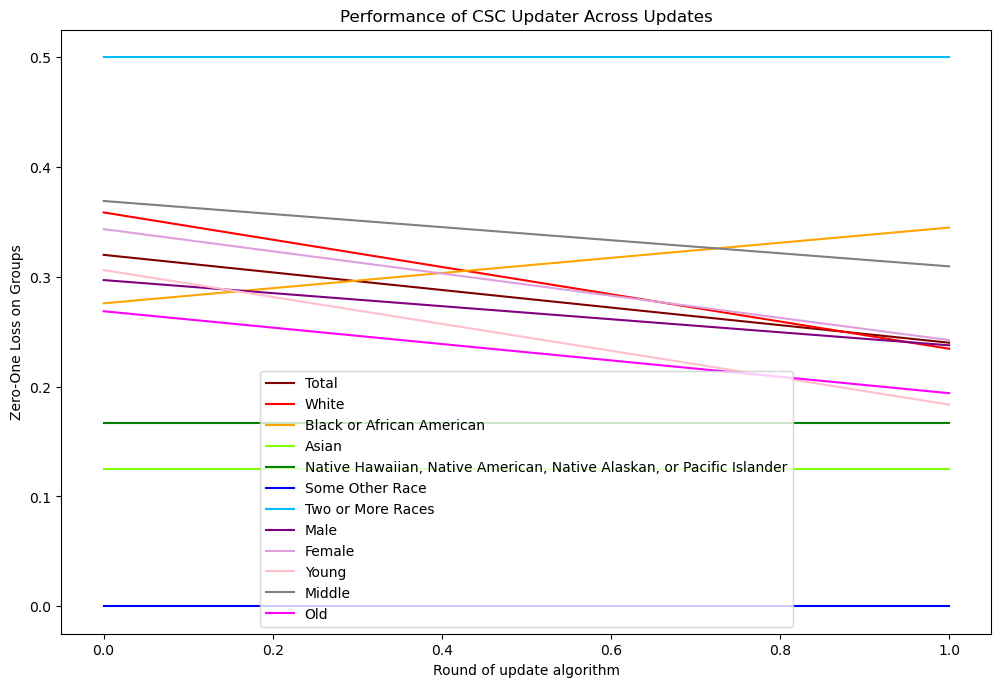

In [8]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # make plot bigger

xs = np.arange(f.num_rounds+1)
colors = ['maroon', 'red', 'orange',
          'chartreuse', 'green', 'blue', 'deepskyblue',
          'purple', 'plum',  'pink', 'gray', 'fuchsia', 'black']
group_indicators =  ['Total'] + demo_group_indicators 
for i in range(len(demo_errs)):
    if demo_errs[i][0] != -1:
        plt.plot(xs, demo_errs[i], color=colors[i], label = group_indicators[i])
plt.legend()
plt.xlabel('Round of update algorithm')
plt.ylabel("Zero-One Loss on Groups")
plt.title("Performance of CSC Updater Across Updates")
plt.savefig("CSC_errs_demo.png")

The actual group errors at the end of the CSC updates are as follows. A "-1" appears in a column if the group error was unable to be calculated due to their not being any individuals present in that group in the test data sample.

In [9]:
y = [demo_errs[i][-1] for i in range(len(demo_errs))]
df = pd.DataFrame([y])
df.columns =  ['Total'] + demo_group_indicators
df

,Total,White,Black or African American,Asian,"Native Hawaiian, Native American, Native Alaskan, or Pacific Islander",Some Other Race,Two or More Races,Male,Female,Young,Middle,Old
0,0.24,0.234483,0.344828,0.125,0.166667,0.0,0.5,0.237624,0.242424,0.183673,0.309524,0.19403


What can we actually say about the g's? What do they look like? At a minimum, can measure how many points are in each discovered group:

In [10]:
def print_group_info(x, fun):
        groups = fun.predicates
        group_ind = fun.pred_names
        g_indices = [g_(x) == 1 for g_ in groups]
        for i in range(len(groups)):
            print("Number of datapoints in group %s:" % group_ind[i], sum(g_indices[i]))

print_group_info(test_x, f)

Number of datapoints in group Total: 200
Number of datapoints in group u_g0: 50


One question is if the CSC approach is really doing anything better than just generating a single deep decision tree on the sample. Here, we look at the demographic errors of doing this

In [11]:
dt = DecisionTreeClassifier(max_depth = 10, random_state=0)
dt.fit(train_x, train_y);

In [12]:
dt_group_errs = []
for g in [lambda x: np.ones(len(x),dtype=bool)] + demo_group_functions:
    indices = g(test_x)==1
    xs = test_x[indices]
    ys = test_y[indices]
    if len(ys)!=0:
        pred_ys = dt.predict(xs)
        dt_group_errs.append(metrics.zero_one_loss(ys, pred_ys))
    else:
        dt_group_errs.append(-1)

In [13]:
dataframe = pd.DataFrame([dt_group_errs, [demo_errs[i][-1] for i in range(len(demo_errs))]])
dataframe.columns = ['Total'] + demo_group_indicators
dataframe.index = ["DT", "CSC"]
dataframe

,Total,White,Black or African American,Asian,"Native Hawaiian, Native American, Native Alaskan, or Pacific Islander",Some Other Race,Two or More Races,Male,Female,Young,Middle,Old
DT,0.24,0.248276,0.275862,0.125,0.166667,0.0,0.5,0.247525,0.232323,0.142857,0.273810,0.268657
CSC,0.24,0.234483,0.344828,0.125,0.166667,0.0,0.5,0.237624,0.242424,0.183673,0.309524,0.194030


It would also be nice to know how well it compares to the version of our algorithm that trains directly on all the demographic models.

In [14]:
import run_demo_updates
import updater
imp.reload(run_demo_updates)
imp.reload(updater)

[demo_update_test_errors, demo_update_train_errors] = run_demo_updates.updater_wrapper(initial_model, demo_group_functions, demo_group_indicators, 
                                 test_x, test_y, train_x, train_y,
                                 classifier = "Decision Tree", dt_depth=10)

Building initial model
Running on group 1/11
Group running on Some Other Race
Error of current model on proposed group: 0.0
Error of h trained on proposed group: 0.5
Group Some Other Race is rejected
.....................................................
Running on group 2/11
Group running on Young
Error of current model on proposed group: 0.30612244897959184
Error of h trained on proposed group: 0.20408163265306123
Running iterative update for group: Young
Model groups prior to update: 
['Total']
Group errors on test set prior to update (over all groups)
[nan nan nan nan nan nan nan nan nan nan nan nan]
Group errors after new group has been prepended to PDL:
[0.29500000000000004, 0.20408163265306123]
Group Weights:
[1.0, 0.245]
No repairs needed.
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old',

Comparing the error of this to our other two models gives us:

In [15]:
demo_updates_test_errors = demo_update_test_errors.dropna()
dataframe = pd.DataFrame([dt_group_errs, [demo_errs[i][-1] for i in range(len(demo_errs))], demo_updates_test_errors.iloc[-1]])
dataframe.columns = ['Total'] + demo_group_indicators
dataframe.index = ["DT", "CSC", "Demographic-Trained PDL"]
dataframe

,Total,White,Black or African American,Asian,"Native Hawaiian, Native American, Native Alaskan, or Pacific Islander",Some Other Race,Two or More Races,Male,Female,Young,Middle,Old
DT,0.24,0.248276,0.275862,0.125000,0.166667,0.000000,0.500000,0.247525,0.232323,0.142857,0.273810,0.268657
CSC,0.24,0.234483,0.344828,0.125000,0.166667,0.000000,0.500000,0.237624,0.242424,0.183673,0.309524,0.194030
Demographic-Trained PDL,0.25,0.000000,0.142857,0.413793,0.250000,0.232323,0.298507,0.267327,0.241379,0.000000,0.273810,0.000000
